In [1]:
import cv2
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

The next snippet is used to plot the depth calculated in the script


In [2]:
def exr2depth(path):
    """Read depth image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None
        
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH)

    # get the maximum value from the array, aka the most distant point
    # everything above that value is infinite, thus i clamp it to maxvalue
    # then divide by maxvalue to obtain a normalized map
    # multiply by 255 to obtain a colormap from the depthmap
    maxvalue = np.max(img[img < np.max(img)])
    img[img > maxvalue] = maxvalue
    img = img / maxvalue * 255

    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

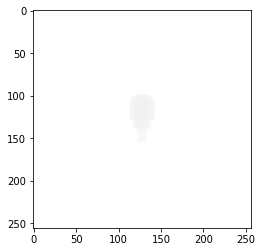

In [3]:
depth_data = exr2depth("./out/0000_000000depth.exr")

fig = plt.figure()
plt.imshow(depth_data)
plt.show()

The next snippet is used to plot the flow

In [5]:
def exr2flow(exr):
    """ converts 1-channel exr-data to 2D numpy arrays """ 
    img = cv2.imread(exr, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    # Compute the size
    sz = img.shape[:2]

    R, G, B =  img[..., 0], img[..., 1], img[..., 2]

    img = np.zeros((sz[1], sz[0], 3), np.float64)
    img[:,:,0] = np.array(R).reshape(img.shape[0],-1)
    img[:,:,1] = -np.array(G).reshape(img.shape[0],-1)

    hsv = np.zeros((sz[1], sz[0], 3), np.uint8)
    hsv[...,1] = 255

    mag, ang = cv2.cartToPolar(img[...,0], img[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    return img, bgr, mag, ang

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


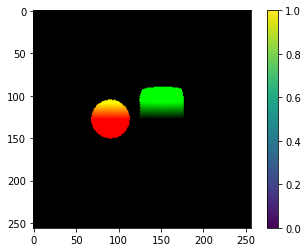

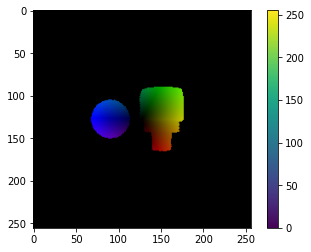

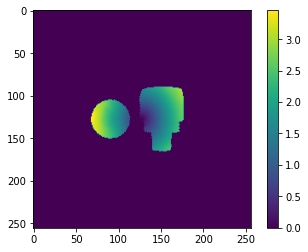

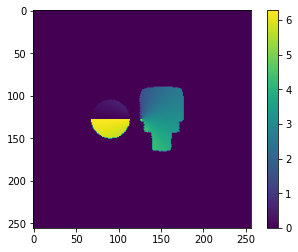

In [5]:
flow_data = exr2flow("./out/0001_000010flow.exr")

for data in flow_data:
    fig = plt.figure()
    plt.imshow(data)
    plt.colorbar()
    plt.show()

The next snippet is used to plot exr images


In [6]:
def exr2normal(path):
    """Read normal map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx3
    """
    if not os.path.isfile(path):
            return None

    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    img[img > 1] = 1
    img[img < 0] = 0
    img = img * 255
    
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

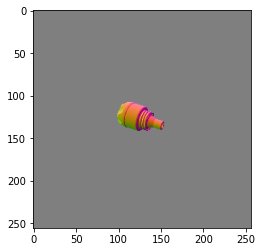

In [7]:
nrm_data = exr2normal("./out/0000_000010normal.exr")

fig = plt.figure()
plt.imshow(nrm_data)
plt.show()

In [8]:
def exr2segmap(path):
    """Read segmentation map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None    

    img = cv2.imread(path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

    img = img[..., 0] + img[..., 1] + img[..., 2]
    img[img <= 0] = 0
    img[img > 0] = 1
    img = np.array(img).astype(np.uint8).reshape(img.shape[0], img.shape[1], -1)

    return img

(256, 256, 1)


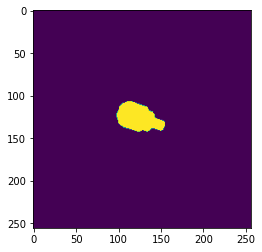

In [10]:
albedo_data = exr2segmap("./out/0000_000010albedo.exr")

fig = plt.figure()
plt.imshow(albedo_data)
plt.show()

In [11]:
def png2rgb(path):
    """Read segmentation map image as numpy array

    Args:
        path (str): The path to the file

    Returns:
        ndarray: Returns an array with the shape WxHx1
    """
    if not os.path.isfile(path):
            return None    

    img = cv2.imread(path)

    return img

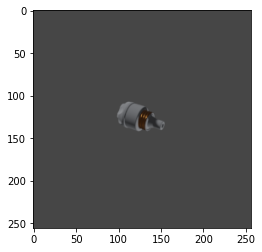

In [14]:
rgb_data = png2rgb("./out/0000_000010rgb.png")
rgb_data = rgb_data[:, :, ::-1]

fig = plt.figure()
plt.imshow(rgb_data)
plt.show()

In [24]:
def txt2label(path):
    if not os.path.isfile(path):
        return None    

    with open(path, 'r') as f:
        l = [x.split() for x in f.read().strip().splitlines()]
        l = np.array(l, dtype=np.float32)
    
    return l


def xywh2xyxy(x):
    y = np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y


def plot_one_box(x, img, label=None):
    # Plots one bounding box on image img
    color = [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=3, lineType=cv2.LINE_AA)
    if label:
        t_size = cv2.getTextSize(label, 0, fontScale=1, thickness=1)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_AA)


def plot_bbox(img, labels):
    labels[:, 1:5] = xywh2xyxy(labels[:, 1:5])

    w, h = img.shape[:2]

    labels[:, [1, 3]] *= w
    labels[:, [2, 4]] *= h

    for label in labels:
        bbox = label[1:5]
        class_name = str(label[0])
        plot_one_box(bbox, img, label=class_name)

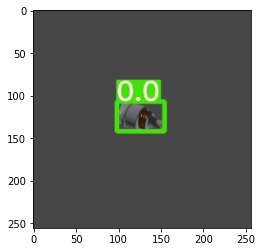

In [25]:
labels = txt2label("./out/0000_000010label.txt")
rgb_data = png2rgb("./out/0000_000010rgb.png")

plot_bbox(rgb_data, labels)

fig = plt.figure()
rgb_data = rgb_data[:, :, ::-1]
plt.imshow(rgb_data)
plt.show()


In [2]:
def pkl2meshes(path):
    """ read pkl file with mesh information. The camera is placed on the bottom plane,
    Z (up) axis measures distance from the camera

    return list of meshes (tuples of vertices and edges)
    """
    with open(path, 'rb') as f:
        meshes = pickle.load(f)
    return meshes

def meshes2volume(meshes, map_size=32):
    volumes = [[list(v) + [c + 1] for v in vs] for (c, vs, _) in meshes]

    voxels = np.concatenate(volumes, axis=0)
    voxels[:, 0] *= (map_size - 1) / max(np.max(voxels[:, 0]), 1)
    voxels[:, 1] *= (map_size - 1) / max(np.max(voxels[:, 1]), 1)
    voxels[:, 2] *= (map_size - 1) / max(np.max(voxels[:, 2]), 1)
    voxels = np.floor(voxels).astype(dtype=np.int64)
    voxels = np.unique(voxels, axis=0)

    volume = np.zeros((map_size, map_size, map_size)).astype(np.int64)
    volume[voxels[:, 0], voxels[:, 1], voxels[:, 2]] = voxels[:, 3]
    return volume

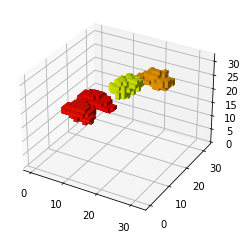

In [3]:
meshes = pkl2meshes("./multi/0000_000010mesh.pkl")
volume = meshes2volume(meshes, map_size=32)

cmap = cm.get_cmap('hsv', 100)
voxels = volume > 0
colors = np.zeros(voxels.shape + (4,))
colors[..., 0:4] = cmap(volume/100)
ax = plt.axes(projection='3d')
ax.voxels(voxels, facecolors=colors,
            edgecolors=np.clip(2*colors - 0.5, 0, 1),
            linewidth=0.5)
plt.show()
